# Autoencoders parte 2

## Colorear imagenes

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, datasets
import numpy as np
import os
import matplotlib.pyplot as plt

### 1. De RGB a Escala de grises

In [2]:
def rgb2gray(rgb):
  # grayscale = 0.299*r + 0.587*g + 0.114*b
  return np.dot(rgb[...,:3],[0.299, 0.587, 0.114])

## 2. Dataset

In [3]:
(x_train, _), (x_test, _) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
# Dimensiones
n_row = x_train.shape[1]
n_col = x_train.shape[2]
n_cha = x_train.shape[3]

In [5]:
# Guardamos las imagenes
imgs_dir = './images'
os.makedirs(imgs_dir)

In [6]:
# Graficamos
imgs = x_test[:25]
imgs = imgs.reshape((5,5,n_row,n_col,n_cha))
imgs = np.vstack([np.hstack(i) for i in imgs])

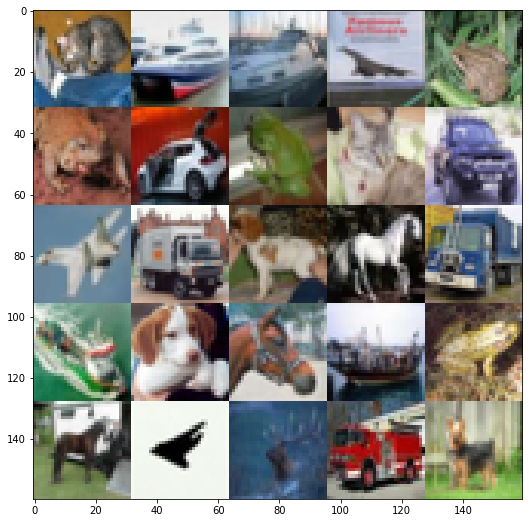

In [7]:
plt.figure(figsize=(9,9))
plt.imshow(imgs)
plt.savefig('./images/test1.png')
plt.show()

In [8]:
### Conversion a escala de grises
x_train_g = rgb2gray(x_train)
x_test_g = rgb2gray(x_test)

In [9]:
# Graficamos la escala de grises
imgs = x_test_g[:25]
imgs = imgs.reshape((5,5,n_row,n_col))
imgs = np.vstack([np.hstack(i) for i in imgs])

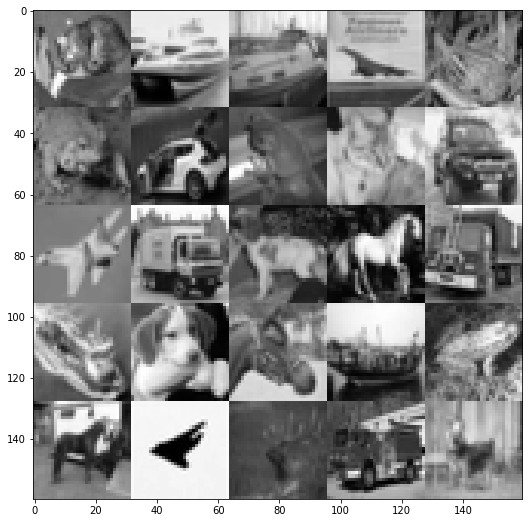

In [10]:
plt.figure(figsize=(9,9))
plt.imshow(imgs, cmap='gray')
plt.savefig('./images/test_gray1.png')
plt.show()

In [11]:
# Normalizacion
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [12]:
# Normalizacion
x_train_g = x_train_g.astype('float32')/255
x_test_g = x_test_g.astype('float32')/255

In [13]:
# Reshape
x_train_g = x_train_g.reshape(-1,n_row,n_col,1)
x_test_g = x_test_g.reshape(-1,n_row,n_col,1)

## 3. Autoencoder

### 3.1. Encoder

In [14]:
input_shape = (n_row,n_col,1)

In [15]:
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = layers.Conv2D(64,3,padding='same',strides=2, activation='relu') (inputs)
x = layers.Conv2D(128,3,padding='same',strides=2, activation='relu') (x)
x = layers.Conv2D(256,3,padding='same',strides=2, activation='relu') (x)
# (4,4,256)
x = layers.Flatten()(x)
output1 = layers.Dense(256, name='latent_vector')(x)
encoder = tf.keras.Model(inputs=inputs, outputs=output1, name='encoder')

In [16]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

### 3.2. Decoder

In [17]:
latent_input = layers.Input(shape=(256,), name='decoder_input')
x = layers.Dense(4096)(latent_input)
x = layers.Reshape((4,4,256))(x)
x = layers.Conv2DTranspose(128,3,padding='same',strides=2, activation='relu')(x)
x = layers.Conv2DTranspose(64,3,padding='same',strides=2, activation='relu')(x)
x = layers.Conv2DTranspose(3,3,padding='same',strides=2, activation='relu')(x)
decoder = tf.keras.Model(inputs=latent_input, outputs=x, name='decoder')

In [18]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        1731

### 3.3. Autoencoder

In [19]:
autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)))

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         1423235   
                                                                 
Total params: 2,841,731
Trainable params: 2,841,731
Non-trainable params: 0
_________________________________________________________________


## 4. Entrenamiento

In [21]:
cb1 = callbacks.ModelCheckpoint('./model.h5',save_best_only=True)
cb2 = callbacks.EarlyStopping(patience=6, restore_best_weights=True)
cb3 = callbacks.ReduceLROnPlateau(factor=0.02, patience=4, min_lr=0.5e-6)

In [22]:
# Compilamos
autoencoder.compile(loss='mse', optimizer='adam')
CB = [cb1,cb2,cb3]

In [28]:
# Entrenamiento
autoencoder.fit(x_train_g,x_train, validation_data=(x_test_g,x_test),
                batch_size=128, epochs=25, callbacks=CB)

Epoch 1/25
391/391 [==============================] - 6s 15ms/step - loss: 0.0053 - val_loss: 0.0071 - lr: 2.0000e-05
Epoch 2/25
391/391 [==============================] - 5s 13ms/step - loss: 0.0052 - val_loss: 0.0071 - lr: 2.0000e-05
Epoch 3/25
391/391 [==============================] - 5s 13ms/step - loss: 0.0051 - val_loss: 0.0071 - lr: 2.0000e-05
Epoch 4/25
391/391 [==============================] - 5s 13ms/step - loss: 0.0051 - val_loss: 0.0071 - lr: 2.0000e-05
Epoch 5/25
391/391 [==============================] - 5s 14ms/step - loss: 0.0051 - val_loss: 0.0071 - lr: 2.0000e-05
Epoch 6/25
391/391 [==============================] - 5s 14ms/step - loss: 0.0051 - val_loss: 0.0071 - lr: 5.0000e-07
Epoch 7/25
391/391 [==============================] - 5s 14ms/step - loss: 0.0050 - val_loss: 0.0071 - lr: 5.0000e-07


In [29]:
# Prueba del modelo
x_predict = autoencoder.predict(x_test_g)

In [30]:
# Graficamos la prediccion
imgs = x_predict[:25]
imgs = imgs.reshape((5,5,n_row,n_col,3))
imgs = np.vstack([np.hstack(i) for i in imgs])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


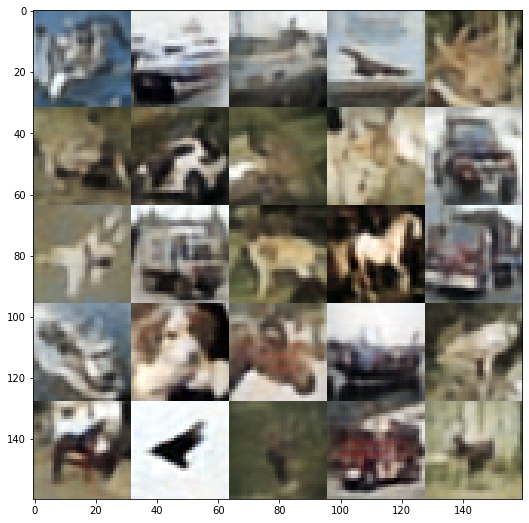

In [31]:
plt.figure(figsize=(9,9))
plt.imshow(imgs, cmap='gray')
plt.savefig('./images/test_predict1.png')
plt.show()